In [1]:
import xarray as xr
import matplotlib.dates as mdates
import numpy as np
import matplotlib
from matplotlib import rcParams
import datetime
import pandas as pd
import cftime
import pylab as plt
import netCDF4 as nc
from numpy import ma
import dask as dd

#stash codes
stash_ch4 = 'mass_fraction_of_methane_in_air'
stash_co = 'mass_fraction_of_carbon_monoxide_in_air'
stash_ch4_oh = 'm01s50i041'
stash_oh = 'mass_fraction_of_hydroxyl_radical_in_air'
stash_o3 = 'mass_fraction_of_ozone_in_air'
stash_trop = 'm01s50i062'
stash_mass = 'm01s50i063'
stash_temp = 'surface_temperature'

#define constants
oh_mr = 17
n_a = 6.022e23

# Altitude data to obtain volumes

data_alt = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/vol_n96.nc')
vol = data_alt.grid_cell_volume
vol = vol.data

#define functions
def molec_cm3(conc_kg_kg, mass, vol, mr):
    molec_box = conc_kg_kg*mass/mr*1000*n_a #molecules per box
    cm3 = molec_box/(vol*1e6) #molec per cm3
    return cm3

In [2]:
# Area and volume datasets

area = nc.Dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/areacella_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc')
box_area = area.variables['areacella'][:]

total_area = np.sum(box_area)
area_scaled = box_area/total_area
lat_area_scaled = area_scaled[:,0]#1D array of latitude scaling values

In [3]:
# OH data extracting and assigning to variables
data_oh = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_oh_PI.nc', chunks={'time':12})
oh_1 = data_oh.variables[stash_oh][:]
time = data_oh.time[:]

# air mass data
data_air_mass = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_airmass_PI.nc', chunks={'time':12})
air_mass = data_air_mass.variables[stash_mass][:]

convert = molec_cm3(oh_1,air_mass,vol,oh_mr)

In [4]:
# Return result to an xarrray DataArray, this of course could be removed if in defining oh_1 the '.variables' part was omitted, but it could cause issues to remove it now and it makes no noticeable
# difference to performance

lat = data_oh.latitude[:]
lon = data_oh.longitude[:]
xtime = data_oh.time[:]

oh_conc_cm3 = xr.DataArray(data=convert,
                           name='oh_conc_molec_cm3',
                           dims=["time","model_level_number","latitude","longitude"], 
                           attrs=dict(
                            standard_name = "mass_fraction_of_hydroxyl_radical_in_air",
                            units = "molec cm-3",
                            dom_stash_source = "oh_molec_cm3",
                            cell_methods = "time: mean (interval: 1 hour)",
                            grid_mapping = "latitude_longitude"  
                           ),
                           coords=dict(
                               time = xtime.data,
                               latitude = (["latitude"], lat.data),
                               longitude = (["longitude"], lon.data)
                           )
                          )


In [5]:
# fast mask - also maybe chunking keeps it within memory limits? yes by not calculating the values at all until the actual plotting step
# without the chunking it fails (confirmed 2022-07-18)
o3 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_o3_PI_run.nc',  chunks = {'time': 12})
o3['mask'] = xr.ones_like(o3.mass_fraction_of_ozone_in_air)
o3['mask'] = o3.mask.where(o3.mass_fraction_of_ozone_in_air<7.544e-8, other =0.)
# o3.mask.to_netcdf('tmp_mask.nc',encoding={"mask": {"dtype": "f8"}}) #output the mask to another file

In [6]:
# mask the airmass to use as weighting, giving 0 weight to the vaules above troposphere
airm_weight_masked = air_mass*o3.mask

In [7]:
oh_trop_mean = dd.array.average(oh_conc_cm3, weights=airm_weight_masked, axis = (1,2,3))
oh_map_mean = dd.array.average(oh_conc_cm3, weights=airm_weight_masked, axis = (1))

In [8]:
## Map Plotting imports

from matplotlib.colors import LinearSegmentedColormap,ListedColormap
from matplotlib import cm
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

In [9]:
oh_map_plot = oh_map_mean.compute()

In [10]:
# Export data to use in difference map

# oh_949 = xr.DataArray(data=oh_map_mean,
#                            name='oh_conc_u-bl949',
#                            dims=["model_level_number","latitude","longitude"], 
#                            attrs=dict(
#                             standard_name = "mass_fraction_of_hydroxyl_radical_in_air",
#                             units = "molec cm-3",
#                             dom_stash_source = "oh_molec_cm3",
#                             cell_methods = "time: mean (interval: 1 hour)",
#                             grid_mapping = "latitude_longitude"  
#                            ),
#                            coords=dict(
#                                latitude = (["latitude"], lat.data),
#                                longitude = (["longitude"], lon.data)
#                            )
#                           )


# oh_949.to_netcdf('Data/u-bl949_oh_map.nc')

Text(0.5, 1.0, 'ubl-949, Methane ')

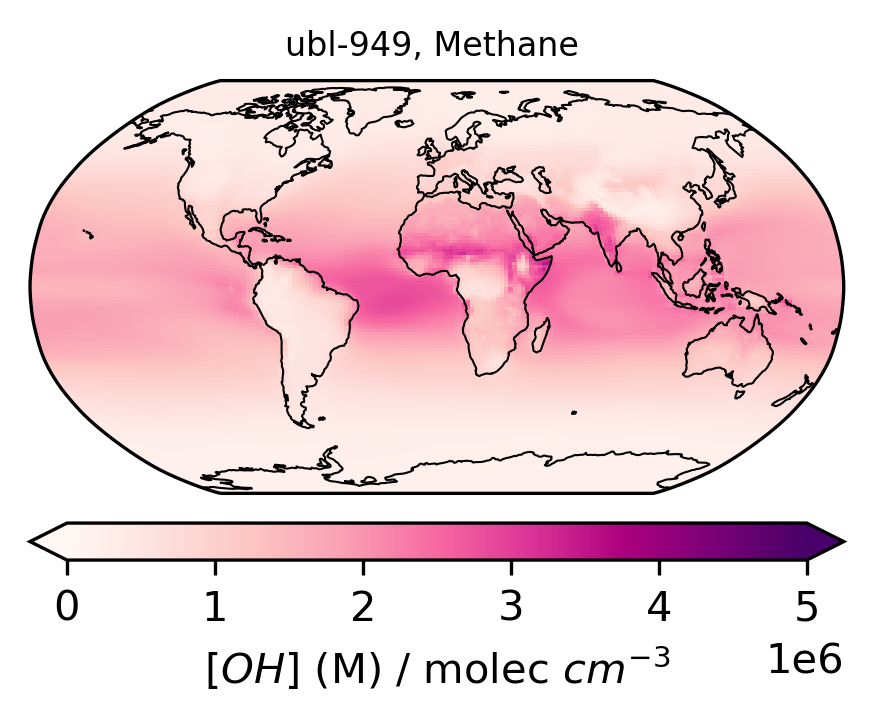

In [11]:
# Plot OH concentration on a map

# top = cm.get_cmap('YlOrRd', 128)
# bottom = cm.get_cmap('RdPu', 128)

# newcolors = np.vstack((top(np.linspace(0, 1, 90)),
#                        bottom(np.linspace(0, 1, 90))))
# newcmp = ListedColormap(newcolors, name='Yel_Pur')



fig = plt.figure(figsize=(3.5,2.625), dpi=300)

ax = plt.axes(projection=ccrs.Robinson(central_longitude=0, globe=None))
ax.set_global()
ax.coastlines(linewidth=0.5)

# I think this is the bit which is responsible for time averaging the surface temperatures by taking the mean of the array over the time dimension
ch4_diff_cyclic, lon_plot = add_cyclic_point(np.mean(oh_map_plot[:,:,:],
                                                     axis=0), coord=lon)   


plt.pcolormesh(lon_plot,lat,ch4_diff_cyclic, cmap='RdPu',transform=ccrs.PlateCarree(central_longitude=0), vmin=0, vmax=5e6)

plt.colorbar(label = '$[OH]$ (M) / molec $cm^{-3}$' ,orientation='horizontal',pad=0.05, extend='both')
plt.title('ubl-949, Methane ',fontsize=8)
# plt.savefig('figures/ubl-949_[OH]_map.png',dpi=300)

In [12]:
## Plotting OH concentration across latitudes

oh_lon_mean = dd.array.average(oh_conc_cm3,axis=(0,1,3))

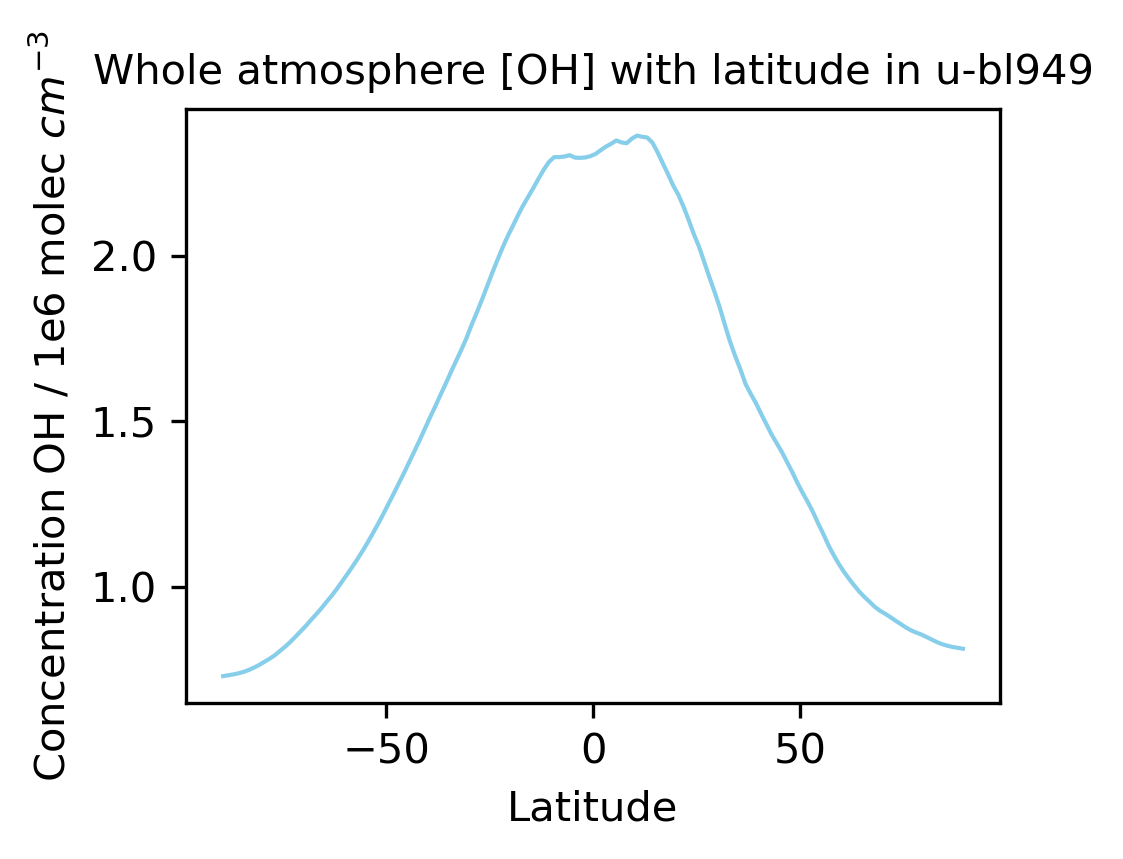

In [13]:
fig = plt.figure(figsize=(3.5,2.625), dpi=300)
ax = plt.axes()

plt.xlabel("Latitude")
plt.ylabel("Concentration OH / 1e6 molec $cm^{-3}$", fontsize=10)
plt.title("Whole atmosphere [OH] with latitude in u-bl949", fontsize=10)

ax.plot(lat,oh_lon_mean/1e6 , c='skyblue', linewidth=1)

In [14]:
# Recreating relevant temperature data to plot both on same plot

data_t = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_surf_temp_1961_2340.nc')

temp = data_t.variables[stash_temp]

temp_lon_mean = np.mean(temp, axis = 2)
mean_sur_temp = np.average(temp_lon_mean,weights = lat_area_scaled, axis = (1)) - 273.15

In [15]:
# Computing here allows the plot to be edited more quickly in Jupyter notebook as it doesn't have to recompute the values every time it plots
oh_gm_plot = oh_trop_mean.compute()

In [16]:
# Export oh GM data to be used in difference plots

# oh_949 = xr.DataArray(data=oh_gm_plot,
#                            name='oh_conc_gm_u-bl949',
#                            dims=["time"], 
#                            attrs=dict(
#                             standard_name = "mass_fraction_of_hydroxyl_radical_in_air",
#                             units = "molec cm-3",
#                             dom_stash_source = "oh_molec_cm3",
#                             cell_methods = "time: mean (interval: 1 hour)",
#                            ),
#                            coords=dict(
#                             time = xtime.data
#                            )
#                           )

# oh_949.to_netcdf('Data/u-bl949_oh_gm.nc')

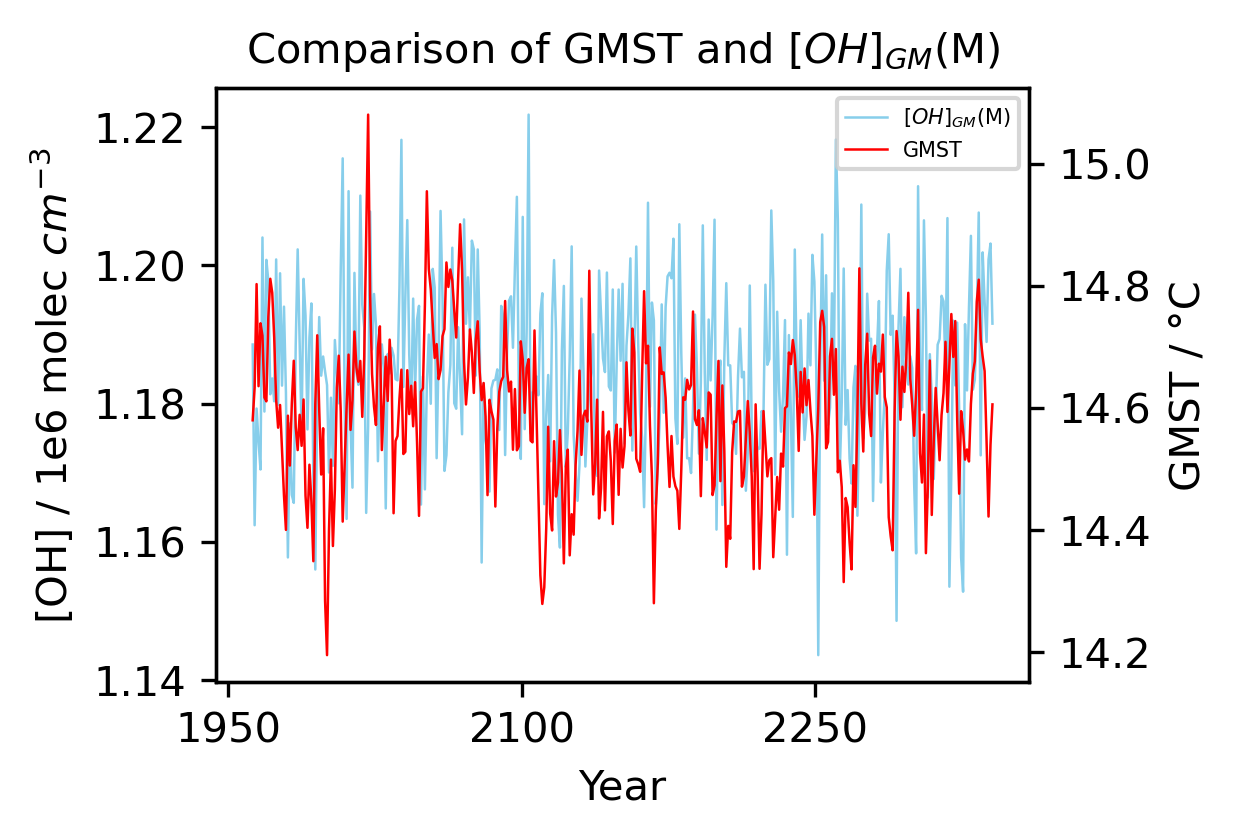

In [17]:
#Plotting of GMST and [OH] together

fig = plt.figure(figsize=(3.5,2.625), dpi=300)
ax = plt.axes()

plt.xlabel("Year")
ax.set_ylabel("[OH] / 1e6 molec $cm^{-3}$", fontsize=10)
plt.title("Comparison of GMST and $[OH]_{GM}$(M)", fontsize=10)

line0, = ax.plot(time, oh_gm_plot/1e6, c='skyblue', linewidth=0.6)

ax1 = ax.twinx()
ax1.set_ylabel("GMST / " '\u00B0' 'C', fontsize=10)

line1, = ax1.plot(time, mean_sur_temp, c='red', linewidth = 0.6)

line0.set_label('$[OH]_{GM}$(M)')
line1.set_label('GMST')
ax.legend(handles=[line0,line1],fontsize=5,loc ='upper right')

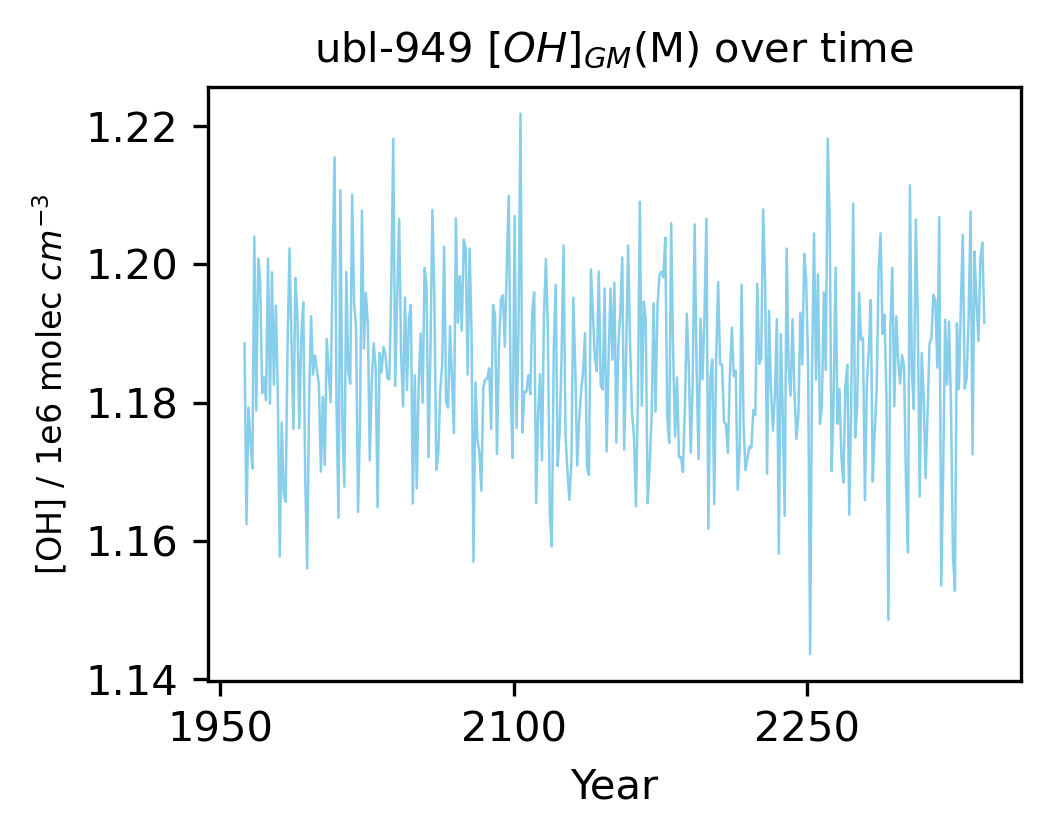

In [18]:
# Plot of just [OH]_GM (M)

fig = plt.figure(figsize=(3.5,2.625), dpi=300)
ax = plt.axes()

plt.xlabel("Year")
ax.set_ylabel("[OH] / 1e6 molec $cm^{-3}$", fontsize=8)
plt.title("ubl-949 $[OH]_{GM}$(M) over time", fontsize=10)

line0, = ax.plot(time, oh_gm_plot/1e6, c='skyblue', linewidth=0.6)

#plt.savefig('ubl-949_[OH]_GM.png',dpi=300)

## Whole atmosphere plots

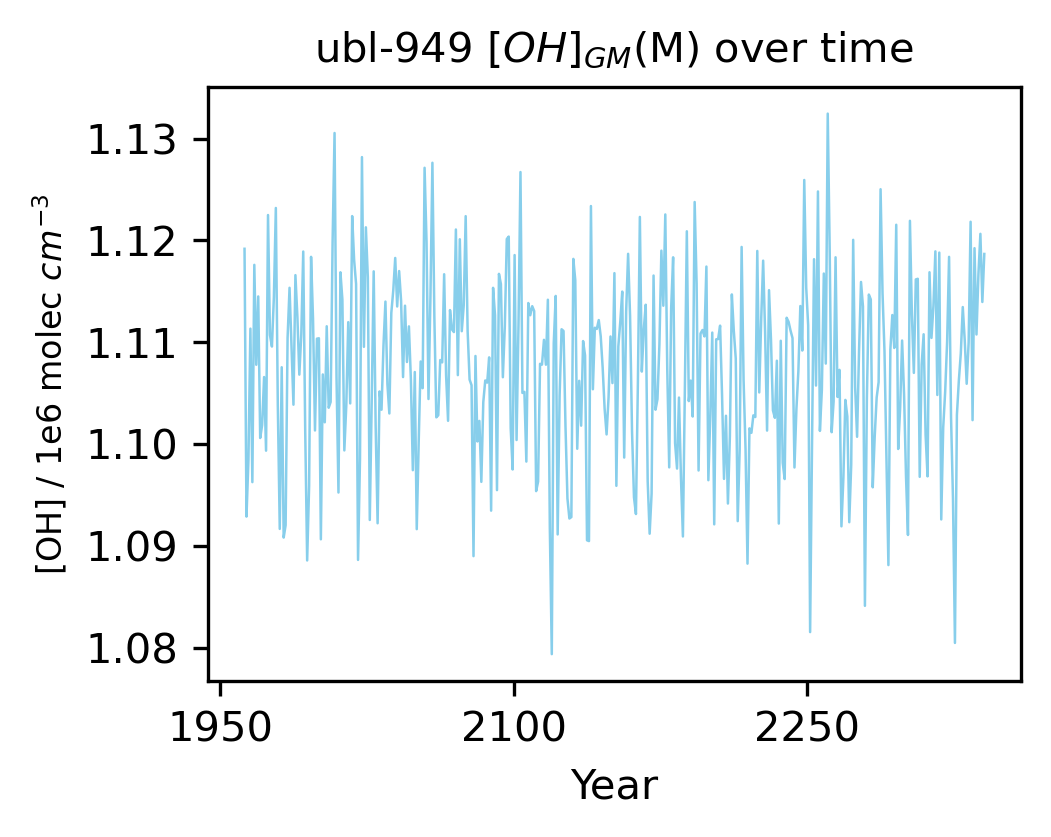

In [19]:
# Check values for whole atmosphere

oh_mean = dd.array.average(oh_conc_cm3, weights=air_mass, axis = (1,2,3))

fig = plt.figure(figsize=(3.5,2.625), dpi=300)
ax = plt.axes()

plt.xlabel("Year")
ax.set_ylabel("[OH] / 1e6 molec $cm^{-3}$", fontsize=8)
plt.title("ubl-949 $[OH]_{GM}$(M) over time", fontsize=10)

line0, = ax.plot(time, oh_mean/1e6, c='skyblue', linewidth=0.6)

In [20]:
# Export some total values

oh_949 = xr.DataArray(data=oh_mean,
                           name='oh_whole_atmos_u-bl949',
                           dims=['time'], 
                           attrs=dict(
                            standard_name = "molec_conc_oh",
                            units = "molec cm-3",
                            dom_stash_source = "oh_molec_cm3",
                            cell_methods = "time: mean (interval: 1 hour)"  
                           ),
                           coords=dict(
                               time = (['time'],time.data)
                           )
                          )


# oh_949.to_netcdf('u-bl949_total_atmos.nc')

In [21]:
###This is the much less reliable function which was replaced with dask data processing to calculate oh conc in molec cm3

# ## Apply function in increments to make processing possible

# #Define array of appropriate size to store result
# res = np.zeros((379,85,144,192))


# # Define there to be 27 increments of 14 years, weird increment as data begins in 1962 not a round number
# ninc = 27
# nyear = 14

# for i in range(ninc):
#     oh = oh_1.data[i*nyear:(i+1)*nyear]
#     airm = air_mass.data[i*nyear:(i+1)*nyear]

# #     oh = oh_1.data[nyear*i]
# #     airm = air_mass.data[i*nyear]
    
#     oh_molec_cm3 = molec_cm3(oh, airm,vol, oh_mr)
    
#     res[i*nyear:(i+1)*nyear,:,:,:] = oh_molec_cm3

# #prime number of entries in the original data so need this line to individually compute the final part
# oh_molec_cm3 = molec_cm3(oh_1.data[378,:,:,:],air_mass.data[378,:,:,:],vol,oh_mr)
# res[378,:,:,:] = oh_molec_cm3

# # Return result to an xarrray dataset

# lat = data_OH.latitude[:]
# lon = data_OH.longitude[:]
# xtime = data_OH.time[:]

# oh_conc_cm3 = xr.DataArray(data=res,
#                            dims=["time","model_level_number","latitude","longitude"], 
#                            attrs=dict(
#                             standard_name = "mass_fraction_of_hydroxyl_radical_in_air",
#                             units = "molec cm-3",
#                             dom_stash_source = "oh_molec_cc",
#                             cell_methods = "time: mean (interval: 1 hour)",
#                             grid_mapping = "latitude_longitude"  
#                            ),
#                            coords=dict(
#                                time = xtime.data,
#                                latitude = (["latitude"], lat.data),
#                                longitude = (["longitude"], lon.data)
#                            )
#                           )
